# Simple orders analysis

We are finally ready to start analysing our order dataset!

Our objective is to get an initial understanding of
- Orders properties
- Their associated `review_scores`

In [1]:
#import modules 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# import your newly coded order training set
from olist.order import Order
# Change `with_distance_seller_customer` to False if you have not yet completed the optional part of challenge 1
orders = Order().get_training_data(with_distance_seller_customer=False)

In [4]:
orders.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000
mean,12.564574,23.747123,0.774420,0.589061,0.100539,4.142237,1.369870,1.013968,136.895781,22.780658
std,9.542359,8.762100,4.747827,0.492007,0.300719,1.296559,2.290895,0.123772,208.701803,21.532648
min,0.533414,2.008009,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000
25%,6.771296,18.337187,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.850000
50%,10.225243,23.235741,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,86.000000,17.170000
75%,15.732506,28.416094,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,24.020000
max,209.628611,155.135463,188.975081,1.000000,1.000000,5.000000,231.000000,5.000000,13440.000000,1794.960000


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97007 entries, 0 to 97014
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            97007 non-null  object 
 1   wait_time           97007 non-null  float64
 2   expected_wait_time  97007 non-null  float64
 3   delay_vs_expected   97007 non-null  float64
 4   order_status        97007 non-null  object 
 5   dim_is_five_star    97007 non-null  int64  
 6   dim_is_one_star     97007 non-null  int64  
 7   review_score        97007 non-null  int64  
 8   number_of_products  97007 non-null  int64  
 9   number_of_sellers   97007 non-null  int64  
 10  price               97007 non-null  float64
 11  freight_value       97007 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


## 1 - Inspect features

❓ Print summary statistics `DataFrame.describe()` of each column of the order dataset, and in particular `wait_time`

Plot various histograms to get a sense of each variable's distribution.
In particular, create a `sns.FacetGrid()` of histograms for each `review_score`

What do you notice for variables `price` and `freight_value` ? Also, analyse `distance_seller_customer` if you have created it in `order.py`

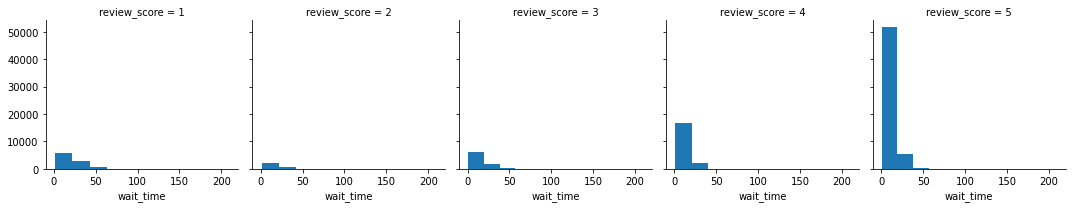

In [6]:
g = sns.FacetGrid(data=orders, col="review_score")
g.map(plt.hist, "wait_time")

<AxesSubplot:xlabel='price', ylabel='Density'>

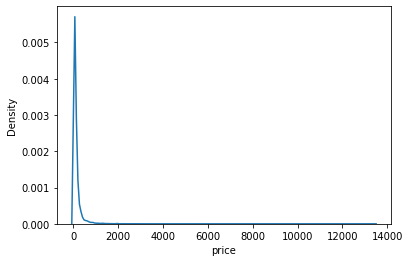

In [7]:
sns.kdeplot(orders['price'])

<AxesSubplot:xlabel='freight_value', ylabel='Density'>

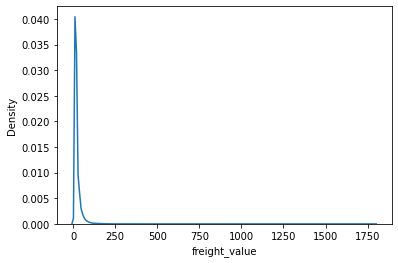

In [8]:
sns.kdeplot(orders['freight_value'])

In [9]:
#sns.kdeplot(orders['distance_seller_customer'])

----
❓Inspect the various correlations between features: which one seems most correlated with `review_score`?

<details>
    <summary>Hint</summary>

`DataFrame.corr()` combined with `sns.heatmap()` and `cmap='coolwarm'`
</details>

<AxesSubplot:>

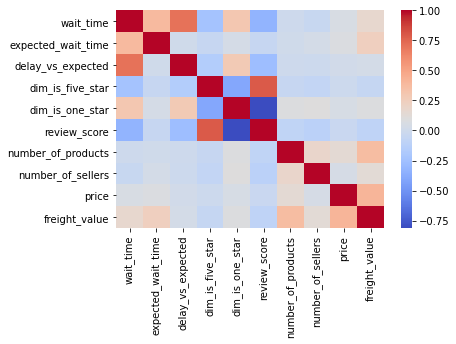

In [10]:
sns.heatmap(orders.corr(), cmap='coolwarm')

## 2 - Simple regression of `review_score` against delivery duration

It seems that `review_score` is mostly correlated with `wait_time` (r = 33%) and `delay_vs_expected` (r=27%).
Let's investigate these with seaborn

### 2.1 Plots
❓ In one figure, create 2 subplots, that regress `review_score` on `wait_time` and `delay_vs_expected` respectively

- Reduce your dataframe to a random subsample of 10,000 rows for speed purposes (a good practice in data exploration)
- use `DataFrame.sample()` with a fixed `random_state` to avoid changing the sample at each execution if needed
- Use `sns.regplot()` to plot the regression line
- Add some `y_jitter` parameters to better visualize the scatterplot density
- Limit `xlim` and `ylim` to hide outliers

In [11]:
sample = orders.sample(10000, random_state=42)

(0.0, 5.864372867009094)

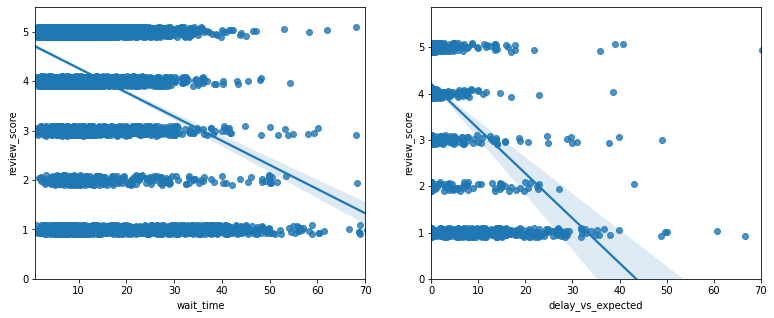

In [12]:
# YOUR PLOT HERE
plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = sample.delay_vs_expected, y= sample.review_score, y_jitter=.1)
plt.xlim(right=70)
plt.ylim(bottom=0)

### 2.2 Interpretation

❓Try to visually 'compute' the `slope` of each curve. Write down, in plain English, how you would interpret these coefficients if you were to explain it to a non-data scientist

In [13]:
# Your answer here

<details>
    <summary>Answer</summary>


- Slope wait_time = -0.05 : "For each additional day an order takes to deliver, the review_score on average is reduced by 0.05"
- Slope delay = -0.1 : "For each additional day an order takes to deliver _above expected_, the review_score on average is reduced by 0.1"

Try to convince yourself intuitively why the latter is more impactful than the former!

### 2.3 Inferential analysis

Even if we used all 100,000 orders for these regplots, they only represent 16 months of data after all.

**How certain** are we that these coefficients are **statistically significant**? i.e that they do not capture random fluctuations due to the limited observation period, and would not generalize well to future orders (all else being equal)?

We need to estimate the **confidence interval** around the mean value for these slopes  
$$slope_{wait} = -0.05 ± \ ?? \ \text{[95% interval]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[95% interval]} $$

Fortunately, seaborn already computes this 95% confidence interval for us with a shaded blue cone around the regression line!

❓Use seaborn `regplot` to visualize the two confidence intervals:
- Change the size of the sample by sub-sampling your dataset: Notice how the slope may change as the sample size becomes smaller. What about the confidence interval?
- Change the size of the confidence interval by playing with regplot `ci` parameter (95% by default)

Text(0.5, 1.0, 'Full dataset (100000 datapoints), Confidence Interval 99%')

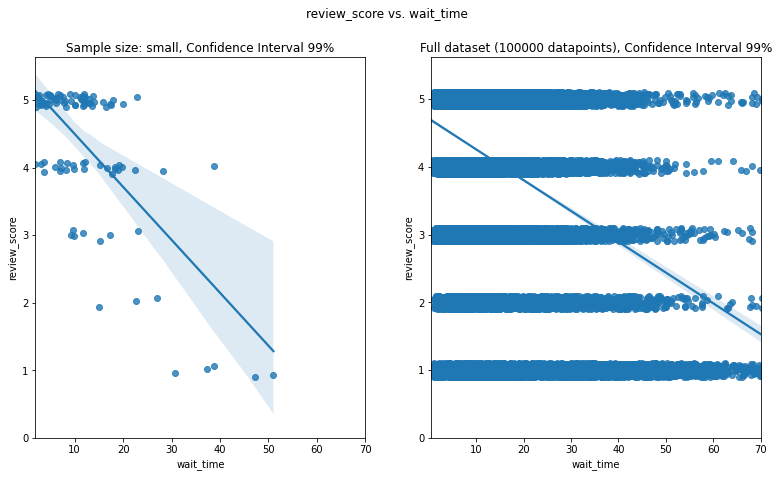

In [14]:
# YOUR PLOT HERE
sample = orders.sample(100, random_state=42)
plt.figure(figsize=(13,7))
plt.suptitle('review_score vs. wait_time')

plt.subplot(1,2,1)
sns.regplot(x = sample.wait_time, y= sample.review_score, y_jitter=.1, ci=99)
plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Sample size: small, Confidence Interval 99%")

plt.subplot(1,2,2)
sns.regplot(x = orders.wait_time, y= orders.review_score, y_jitter=.1, ci=99)
plt.xlim(right=70)
plt.ylim(bottom=0)
plt.title("Full dataset (100000 datapoints), Confidence Interval 99%")

<details>
    <summary>🔎 Interpretation</summary>

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
- We are 95% confident that slower deliveries are associated with weaker reviews.
- The `p-value` associated with the null-hypothesis "review_score is not related to delivery duration" is close to 0, and we can safely reject this hypothesis

$\implies$ Our findings are said to be **statistically significant**. 

However, **correlation does not imply causality**. It may well be that some products, which happen to be inherently slow to deliver on average (heavy ones maybe?) also happen to have a consistently low review_score, however long they take to be delivered. Identifying these **confounding factor** is crucial and cannot be done with simple univariate regression. We will see tomorrow the power of multivariate linear regression. 
</details>



🏁 Congratulations! Don't forget to commit and push your notebook